In [1]:
%pylab inline 
%load_ext autoreload
%autoreload 2
import numdifftools as nd
import tensorflow as tf
import numpy as np
import flowpm
import flowpm.tfpower as tfpower
import flowpm.scipy.interpolate as interpolate
from DifferentiableHOS.pk import pk as pkl
import pickle

Populating the interactive namespace from numpy and matplotlib


In [2]:
nsteps=11
nc=32
box_size=128
Omega_c=0.2589
sigma8=0.8159

In [3]:
def compute_initial_cond(Omega_c):
    # Instantiates a cosmology with desired parameters
    cosmology = flowpm.cosmology.Planck15(Omega_c=Omega_c)
    stages = np.linspace(0.1, 1., nsteps, endpoint=True)
    # Compute linear matter power spectrum
    k = tf.constant(np.logspace(-4, 1, 256), dtype=tf.float32)
    pk = tfpower.linear_matter_power(cosmology, k)
    pk_fun = lambda x: tf.cast(tf.reshape(interpolate.interp_tf(tf.reshape(tf.cast(x, tf.float32), [-1]), k, pk), x.shape), tf.complex64)

    # And initial conditions
    initial_conditions = flowpm.linear_field([nc, nc, nc],
                                           [box_size, box_size,
                                           box_size],
                                           pk_fun,
                                           batch_size=1)
    return initial_conditions 

In [4]:
initial_conditions=compute_initial_cond(Omega_c).numpy()

In [5]:
@tf.function
def compute_Nbody_deriv(Omega_c):
    """ Computes a N-body simulation for a given
    set of cosmological parameters
    """
    # Instantiates a cosmology with desired parameters
    cosmology = flowpm.cosmology.Planck15(Omega_c=Omega_c)
    stages = np.linspace(0.1, 1., nsteps, endpoint=True)

    state = flowpm.lpt_init(cosmology, initial_conditions, 0.1)


    # Evolve particles from initial state down to a=af
    final_state = flowpm.nbody(cosmology, state, stages, [nc, nc,  nc])         

    # Retrieve final density field i.e interpolate the particles to the mesh
    final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])
    final_field=tf.reshape(final_field, [nc, nc, nc])
    params = tf.stack([Omega_c])
    k, power_spectrum = pkl(final_field,shape=final_field.shape,boxsize=np.array([box_size, box_size,
                                               box_size]),kmin=0.1,dk=2*np.pi/box_size)
    return  power_spectrum

In [6]:
theoretical, numerical=tf.test.compute_gradient(
    compute_Nbody_deriv, [0.2589], delta=0.01)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


In [7]:
@tf.function
def Flow_jac(Omega_c):
    """ Computes a N-body simulation for a given
    set of cosmological parameters
    """
    params = tf.stack([Omega_c])
    with tf.GradientTape() as tape:
        tape.watch(params)
        cosmology = flowpm.cosmology.Planck15(Omega_c=params[0])
        stages = np.linspace(0.1, 1., nsteps, endpoint=True)
        state = flowpm.lpt_init(cosmology, initial_conditions, 0.1)


        # Evolve particles from initial state down to a=af
        final_state = flowpm.nbody(cosmology, state, stages, [nc, nc,  nc])         

        # Retrieve final density field i.e interpolate the particles to the mesh
        final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])
        final_field=tf.reshape(final_field, [nc, nc, nc])
        k, power_spectrum = pkl(final_field,shape=final_field.shape,boxsize=np.array([box_size, box_size,
                                               box_size]),kmin=0.1,dk=2*np.pi/box_size)
    return tape.jacobian(power_spectrum, params,experimental_use_pfor=False),k
    

In [8]:
jacobian,k =Flow_jac(0.2589)

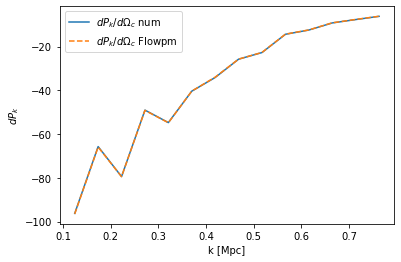

In [9]:
plot(k, numerical[0], label=r'${d P_k}/{d \Omega_c}$ Finite Difference')
plot(k, jacobian[:,0],'--',label=r'${d P_k}/{d \Omega_c}$ Automatic Differentiation')
xlabel('k [Mpc]')
ylabel('$dP_k$')
legend()
savefig('psfinit.png',dpi=175)